In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa
import torch
import torchaudio
from SED_CRNN import CRNN
from readers.featurizer import Wave2Mel

# import sys
# sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID')
ROOT = "F:/DATAS/NEUCOUGHDATA_COUGHSINGLE/"

# Step 1 观察数据集

## 1.1 尝试根据时间截取片段

In [2]:
slice_raw = pd.read_csv(ROOT+'neucough_metainfo_slice.txt', header=0, index_col=None)
slice_raw

,fileid,st,en,gender,issmoking,isalcohol,iscough,isfever,isrespill,iscovid19,...,q26,q31,q38,q60,q61,q62,q63,q64,duration,slice
0,20240921104740,3:04.34,03:04.64,1,0,0,1,0,3,0,...,3,3,1,2,2,1,3,4,186.2269,0.299
1,20240921104740,3:04.62,03:04.88,1,0,0,1,0,3,0,...,3,3,1,2,2,1,3,4,186.2269,0.259
2,20240921104740,3:04.86,03:05.12,1,0,0,1,0,3,0,...,3,3,1,2,2,1,3,4,186.2269,0.259
3,20240921125652,3:01.50,03:01.93,0,0,0,0,0,0,0,...,3,1,1,1,2,3,2,1,185.0453,0.430
4,20240921125652,3:02.16,03:02.55,0,0,0,0,0,0,0,...,3,1,1,1,2,3,2,1,185.0453,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,20241008201738,3:36.63,3:37.03,1,0,0,0,0,0,0,...,1,1,1,1,2,1,1,1,219.6239,0.400
317,20241008201738,3:37.09,3:37.49,1,0,0,0,0,0,0,...,1,1,1,1,2,1,1,1,219.6239,0.400
318,20241008204801,3:30.95,3:31.16,0,0,0,0,0,0,0,...,3,4,1,2,2,2,2,2,217.0756,0.210
319,20241008204801,3:31.35,3:31.56,0,0,0,0,0,0,0,...,3,4,1,2,2,2,2,2,217.0756,0.210


### 尝试一下标准化

F:/DATAS/NEUCOUGHDATA_FULL/20240921104740_audiodata_元音字母a.wav
sample rate: 22050


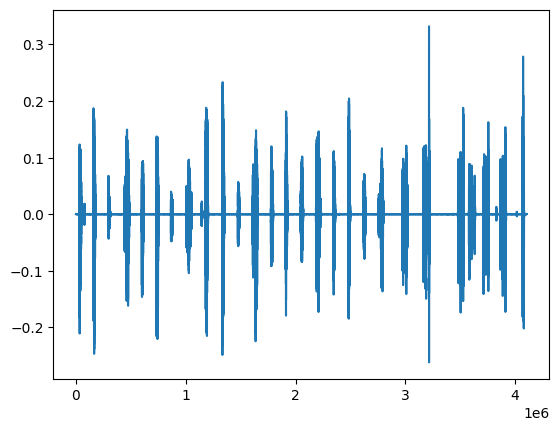

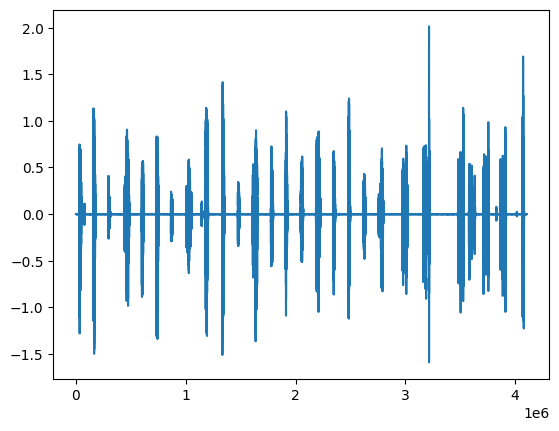

In [4]:
single_file = slice_raw.iloc[2, 0]
single_file_name = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(single_file)
print(single_file_name)
x, sr = librosa.load(single_file_name)
print("sample rate:", sr)

def rms_db(samples):
    """返回以分贝为单位的音频均方根能量

    :return: Root mean square energy in decibels.
    :rtype: float
    """
    # square root => multiply by 10 instead of 20 for dBs
    mean_square = np.mean(samples ** 2)
    return 10 * np.log10(mean_square)

def gain_db(sample, gain):
    return sample * 10.**(gain/20.)

def normalize(sample, target_db=-20, max_gain_db=300.0):
    if -np.inf == rms_db(sample):
        return
    gain = target_db - rms_db(sample)
    if gain > max_gain_db:
        raise ValueError(
            "无法将段规范化到 %f dB，因为可能的增益已经超过max_gain_db (%f dB)" % (target_db, max_gain_db))
    return gain_db(sample, min(max_gain_db, target_db - rms_db(sample)))

new_sample = normalize(x)
plt.figure(0)
plt.plot(x)
plt.figure(1)
plt.plot(new_sample)

# 根据标注的音频，读取srt然后根据区间判断是否静音，用时间窗作为单位
### 静音为01标注
### 读取ass字幕文件

## 读取单个文件的歌词和音频并切分出每个片段

In [ ]:
def min2sec(t: str):
    parts = t.split(':')
    return int(parts[1]) * 60 + float(parts[2])

def read_ass_to_segs(asspath):
    fin = open(asspath, 'r', encoding="UTF-8")
    offset = 20
    while offset>0:
        fin.readline()
        offset -= 1
    intervals = []
    line = fin.readline()
    while line:
        parts = line.strip().split(',')
        # print(parts[1], parts[2], parts[-1])
        intervals.append((min2sec(parts[1]), min2sec(parts[2])))
        line = fin.readline()
    fin.close()
    return intervals

### 通过区间和IOU获取标注
- 截取段的起讫分别为st_pos, en_pos
- 判断段的起讫有三种，(st_pre, en_pre),(st_cur, en_cur),(st_tail, en_tail)
- 如果st_pos > st_cur 且 en_pos<en_cur， 则直接赋值为1 ([])
- 如果st_pos > st_cur 且 en_pos>en_cur，再判断en_pos和st_tail的大小 [(])
- 如果en_pos > st_cur 且 st_pos < st_cur， 再判断st_pos和en_pre的大小 ([)]

当st_cur, en_cur被扫过之后，更新每个的赋值

In [28]:
def read_audio_for_silence(wavname):
    intervals = read_ass_to_segs("F:/DATAS/NEUCOUGHDATA_FULL/{}_annotations.ass".format(wavname))
    print(intervals)
    sample, sr = librosa.load("F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(wavname))
    step, overlap = 8000, 2000
    st_pos, en_pos = 0, step
    st_pre, en_pre = -6001, -1
    Length = len(sample)
    st_cur, en_cur = int(intervals[0][0]*sr), int(intervals[0][1]*sr)
    st_tail, en_tail = int(intervals[1][0]*sr), int(intervals[1][1]*sr)
    jdx = 2
    Segs_List = []
    label_List = []
    tr = 3000
    while en_cur < Length:
        if st_pos > st_cur:
            if en_pos < en_cur:
                label_List.append(1)  # ()([])()
            elif st_pos < en_cur:
                if en_cur - st_pos > tr:
                    label_List.append(1)  # ()([)]()
                else:
                    label_List.append(0)
            elif st_pos > en_cur:
                if en_pos > st_tail:
                    if en_pos - st_tail>tr:
                        label_List.append(1)  # ()()[(])
                    else:
                        label_List.append(0)
                else:
                    label_List.append(0)  # ()()[]()
        elif en_pos > st_cur:
            if en_pos - st_cur > tr:
                label_List.append(1)  # ()[(])()
            else:
                label_List.append(0)
        elif st_pos < en_pre:
            if en_pre - st_pos > tr:
                label_List.append(1)  # ([)]()()
            else:
                label_List.append(0)
        else:
            label_List.append(0)  # ()[]()()
        # print("st_pos:{}, en_pos:{},\nst_cur:{}, en_cur:{},\njdx:{}, interval:{},\nlen(label_List):{}, Length / step:{}, Length:{}".format(st_pos, en_pos, st_cur, en_cur, jdx, len(intervals), len(label_List), Length / step, Length))
        Segs_List.append(sample[st_pos:en_pos+overlap])
        if st_pos > en_cur:
            st_pre, en_pre = st_cur, en_cur
            st_cur, en_cur = st_tail, en_tail
            if jdx < len(intervals):
                st_tail, en_tail = int(intervals[jdx][0] * sr), int(intervals[jdx][1] * sr)
                jdx += 1
            else:
                st_tail, en_tail = Length + 1, Length + step
        st_pos, en_pos = en_pos, en_pos + step
    return Segs_List, label_List

Segs_List, label_List = read_audio_for_silence(wavname="20240921111118")
print(len(Segs_List),'\n', label_List)

[(2.48, 3.12), (8.91, 9.78), (14.87, 15.43), (22.48, 23.24), (23.28, 23.82), (23.82, 24.28), (30.87, 31.69), (35.51, 36.27), (40.55, 41.28), (47.17, 47.84), (47.81, 48.37), (48.4, 48.93), (55.94, 56.72), (62.29, 63.13), (68.27, 68.94), (74.53999999999999, 75.23), (75.25, 75.86), (75.88, 76.39), (82.74, 83.27), (88.16, 88.91), (94.05, 94.50999999999999), (100.38, 101.0), (100.96000000000001, 101.57), (101.59, 102.1), (106.97999999999999, 107.49000000000001), (114.97, 115.88), (120.89, 121.64), (127.37, 128.03), (127.99, 128.67), (128.68, 129.07), (137.55, 140.44), (148.43, 149.07999999999998), (149.16, 149.76), (149.76, 150.22), (150.32999999999998, 150.84), (155.88, 156.71), (156.68, 157.29), (157.51, 157.88), (158.16, 158.69), (162.27, 162.96), (162.99, 163.61), (163.71, 164.2), (164.45, 164.88), (170.04, 170.73), (170.74, 171.49), (171.53, 171.95), (172.17000000000002, 172.61), (176.89, 177.57999999999998), (177.77, 178.46), (178.42000000000002, 178.84), (179.15, 179.57), (185.28, 18

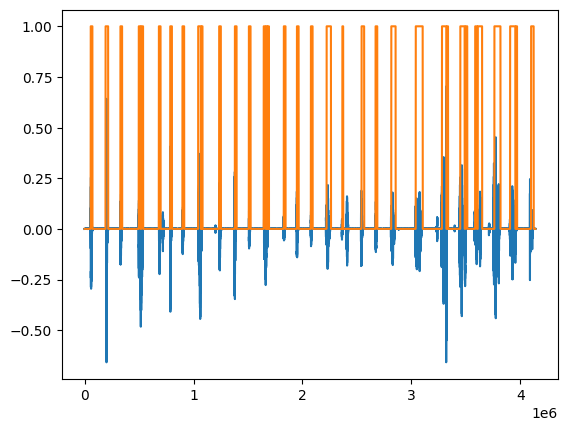

In [29]:
sample, sr = librosa.load("F:/DATAS/NEUCOUGHDATA_FULL/20240921111118_audiodata_元音字母a.wav")
new_List = []
repeat = len(sample) // len(label_List)
for item in label_List:
    for _ in range(repeat):
        new_List.append(item)
plt.figure(0)
plt.plot(sample)
plt.plot(new_List)

F:/DATAS/NEUCOUGHDATA_FULL/20240927150832_audiodata_元音字母a.wav
sample rate: 22050


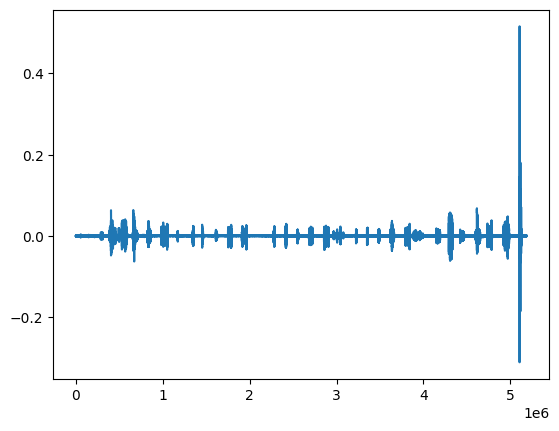

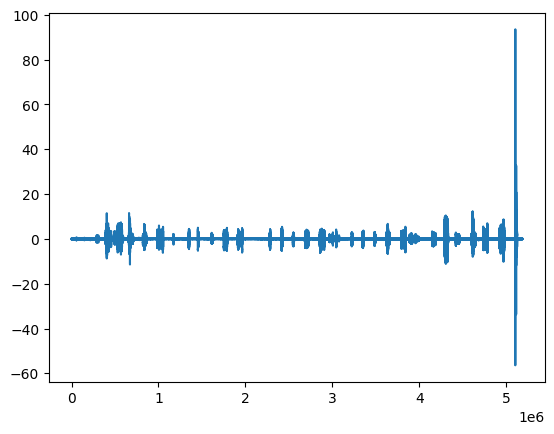

In [26]:
def segment_cough(x, fs, cough_padding=0.2, min_cough_len=0.2, th_l_multiplier=0.1, th_h_multiplier=2):
    # Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    cough_mask = np.array([False] * len(x))

    # Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h = th_h_multiplier * rms

    # Segment coughs
    coughSegments = []
    padding = round(fs * cough_padding)
    min_cough_samples = round(fs * min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01 * fs)
    below_th_counter = 0

    for i, sample in enumerate(x ** 2):
        if cough_in_progress:
            if sample < seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i + padding if (i + padding < len(x)) else len(x) - 1
                    cough_in_progress = False
                    if (cough_end + 1 - cough_start - 2 * padding > min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end + 1])
                        cough_mask[cough_start:cough_end + 1] = True
            elif i == (len(x) - 1):
                cough_end = i
                cough_in_progress = False
                if (cough_end + 1 - cough_start - 2 * padding > min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end + 1])
            else:
                below_th_counter = 0
        else:
            if sample > seg_th_h:
                cough_start = i - padding if (i - padding >= 0) else 0
                cough_in_progress = True

    return coughSegments, cough_mask
# ==================-----------------------------------======================
single_file = slice_raw.iloc[55, 0]
single_file_name = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(single_file)
print(single_file_name)
x, sr = librosa.load(single_file_name)
print("sample rate:", sr)
step_length, full_length = 8000, len(x)
st_pos, en_pos = 0, step_length
if en_pos > full_length:
    segs = [x]
seg_List = []
rms_List = []

while en_pos < full_length:
    seg_List.append(x[st_pos:en_pos])
    rms_List.append(np.sqrt(np.mean(np.square(x[st_pos:en_pos]))))
    

# 粗暴且不好用的方法
瞎猜一个参数区分割，显然完全不准确

In [ ]:
plt.figure(0)
plt.plot(x)
# aoeiu ×(4+4)=40, +1 +3
segs, masks = segment_cough(x, fs, cough_padding=0.03, min_cough_len=0.16, th_l_multiplier=0.0001, th_h_multiplier=0.2)
print("读取文件：", single_file_name)
print("非静音的段数：", len(segs), ", 同长度掩码长度：", len(masks))

for jdx, seg in enumerate(segs):
    plt.figure(jdx)
    plt.plot(seg)

test_seg = np.zeros(len(masks))
for j in range(len(masks)):
    if masks[j]:
        test_seg[j] = 1

plt.figure(44)
plt.plot(test_seg)

In [ ]:
def read_audio(filepath: str, st=None, en=None):
    # print(y.shape, sr)
    # sr = 22050
    if (st is not None) and (en is not None):
        # st, en = int(st * sr), int(en * sr)
        # print("st, en:", st, en)
        y, sr = librosa.load(filepath, offset=st, duration=en - st)
        # print("y, sr:", len(y), sr)
    else:
        y, sr = librosa.load(filepath, )
        # print("y, sr:", y, sr)
    # print(y.shape)
    # mel = w2m(torch.from_numpy(y))
    return y, sr#  , mel

In [ ]:
for idx, item in enumerate(slice_raw.itertuples()):
    if idx >0:
        break
    name, st, en = item[0], item[1], item[2]
    print(name, st, en)
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    y = read_audio(audio_path, st=min2sec(st), en=min2sec(en))
    # plt.subplot(5, 1, idx+1)
    plt.figure(idx, figsize=(14, 5))
    plt.plot(y)

## 1.2 统计波形长度直方图

In [ ]:

sns.displot(slice_raw, x="slice", bins=10, height=4, aspect=3)

# Step 2 统计Mel谱图的形状，统一长度，长的Crop短的Padding

## 2.1 读取、按时间切分、转换Mel谱

In [ ]:

class Wave2Mel(object):
    def __init__(self, sr,
                 n_fft=1024,
                 n_mels=128,
                 win_length=1024,
                 hop_length=512,
                 power=2.0
                 ):
        self.mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                                                  win_length=win_length,
                                                                  hop_length=hop_length,
                                                                  n_fft=n_fft,
                                                                  n_mels=n_mels,
                                                                  power=power)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(stype='power')

    def __call__(self, x):
        return self.amplitude_to_db(self.mel_transform(x))

In [ ]:
mel_length_list = []
sr_list = []
w2m = Wave2Mel(sr=22050)
fout = open("F:/DATAS/NEUCOUGHDATA_COUGHSINGLE/neucough_slicemel.txt", 'w')
fout.write("filename,duration,slice\n")
for idx, item in tqdm(enumerate(slice_raw.itertuples()), desc="Wav2Mel:"):
    name, st, en = item[0], item[1], item[2]
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    y, sr = read_audio(audio_path, st=min2sec(st), en=min2sec(en))
    sr_list.append(sr)

    mel = w2m(torch.from_numpy(y))
    dim, length = mel.data.numpy().shape
    mel_length_list.append([name, len(y), length])
    fout.write("{},{},{}\n".format(name, len(y), length))
fout.close()

In [ ]:
mel_raw = pd.read_csv(ROOT+'neucough_slicemel.txt', header=0, index_col=0)
mel_raw

## 2.2 统计Mel谱的长度统计直方图

In [ ]:
mel_raw["slice"].mean()

In [ ]:
sns.displot(mel_raw, x="slice", bins=10, height=4, aspect=3)

## 2.3 统一长度，长的Crop短的Padding

### 当前存在一个问题：有的很长，可以随机截取多个，而不是只要一个

In [ ]:
fixed_length = 16
for idx, item in enumerate(slice_raw.itertuples()):
    name, st, en = item[0], item[1], item[2]
    st, en = min2sec(st), min2sec(en)
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    y, sr = read_audio(audio_path, st=min2sec(st), en=min2sec(en))
    mel = w2m(torch.from_numpy(y)).data.numpy()
    dim, length = mel.shape
    if length < 16:
        new_mel = np.zeros((128, 16))
        st = np.random.randint(0, (fixed_length-length+1)//2)
        new_mel[:, st:st+16] = mel
    elif length>16:
        st = np.random.randint(0, (length+1-fixed_length)//2)
        new_mel = mel[:, st:st+16]
    else:
        new_mel = mel
        # print("wav, mel length:", len(y), mel.shape)
    print(new_mel.shape)

# Step 3 从原始音频中随机截取一些负样本，作为训练，和Region Proposal

## 寻找切分多大的范围内，波形的mel谱才是16

In [ ]:
def min2sec(t: str):
    parts = t.split(':')
    return int(parts[0]) * 60 + float(parts[1])

def get_rand_start(sec: int, wav_length:int, mode="left", full_length: int=None, sr=22050):
    """ 除法/不要写成//，会导致算什么都是0 """
    if mode=="left":
        return np.random.randint(0, sec*sr-wav_length) / sr
    elif mode=="right":
        return np.random.randint(sec*sr, full_length-wav_length) / sr
    else:
        raise Exception("Unknown mode of get_rand_start(mode=\"???\").")

def read_audio(filepath: str, st=None, en=None, duration=None):
    # print(y.shape, sr)
    # sr = 22050
    if st is not None:
        if en is not None:
            # st, en = int(st * sr), int(en * sr)
            # print("st, en:", st, en)
            y, sr = librosa.load(filepath, offset=st, duration=en - st)
            # print("y, sr:", len(y), sr)
        elif duration is not None:
            y, sr = librosa.load(filepath, offset=st, duration=duration)
    else:
        y, sr = librosa.load(filepath)
            # print("y, sr:", y, sr)
    # print(y.shape)
    # mel = w2m(torch.from_numpy(y))
    return y, sr#  , mel

In [ ]:
def labelling_by_IOU(st1:int, en1:int, st2:int, d2:int, mode="left"):
    print(st1,en1,st2,d2)
    if mode=="left":
        if st2+d2<st1:
            return 0  # other
        elif (st2+d2-st1)/(en1-st2) > 0.2:
            return 1
        else:
            return 0
    else:
        raise Exception("Unknown mode of labelling_by_IOU(mode=\"???\")")

In [ ]:
lab2name = {0: "non-cough", 1:"cough"}
fixed_length = 16
for idx, item in enumerate(slice_raw.itertuples()):
    name, st, en = item[0], item[1], item[2]
    st, en = min2sec(st), min2sec(en)
    print("st, en:", st, en)
    audio_path = "F:/DATAS/NEUCOUGHDATA_FULL/{}_audiodata_元音字母a.wav".format(name)
    pos_sample, sr = read_audio(audio_path, st=st, en=en)
    pos_mel = w2m(torch.from_numpy(pos_sample).to(torch.float32))
    print("pos_sample:", pos_sample.shape, pos_mel.shape)
    print("label:", 1, lab2name[1])
    
    mel16_rand_wavlen = np.random.randint(7680, 8192)  # Mel length: 16
    print("wavlen:", mel16_rand_wavlen/sr)
    rand_start = get_rand_start(sec=st, wav_length=mel16_rand_wavlen, mode="left", full_length=None, sr=22050)
    print("rand_start:", rand_start)
    neg_sample, _ = read_audio(audio_path, st=rand_start, duration=mel16_rand_wavlen/sr)  # 除法/不要写成//，会导致算什么都是0
    neg_mel = w2m(torch.from_numpy(neg_sample).to(torch.float32))
    print("neg_sample:", neg_sample.shape, neg_mel.shape)
    gen_label = labelling_by_IOU(st1=st,en1=en,st2=rand_start,d2=mel16_rand_wavlen/sr)
    print("label:", gen_label, lab2name[gen_label])
    while gen_label==1:
        mel16_rand_wavlen = np.random.randint(7680, 8192)  # Mel length: 16
        print("wavlen:", mel16_rand_wavlen/sr)
        rand_start = get_rand_start(sec=st, wav_length=mel16_rand_wavlen, mode="left", full_length=None, sr=22050)
        print("rand_start:", rand_start)
        neg_sample, _ = read_audio(audio_path, st=rand_start, duration=mel16_rand_wavlen/sr)  # 除法/不要写成//，会导致算什么都是0
        print("neg_sample:", neg_sample.shape)
        gen_label = labelling_by_IOU(st1=st,en1=en,st2=rand_start,d2=mel16_rand_wavlen/sr)
        print("label:", gen_label, lab2name[gen_label])
    print()
    if idx>2:
        print("idx:", idx, mel16_rand_wavlen)
        break

# Step 4 均等分割一条数据

## 4.1 KMeans聚类算法

### RMS能量计算
- 想法：带重叠滑动窗口获取样本，然后画图看一看是否可分
- 然后多个文件一起，线性判别分析

In [ ]:
import os
import numpy as np
import random
import librosa
import matplotlib.pyplot as plt

In [ ]:
def sig2rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

def threshold2x(x, tr, mode="origin"):
    if mode=="origin":
        return x if x > tr else 0
    elif mode=="label":
        return 1 if x > tr else 0
    else:
        raise Exception("Error mode of threshold2x {}, please choise from [\"origin\", \"label\"].".format(mode))

def file2rmslist(filepath):
    fixed_length = 8191  # mel 16
    overlap = 2048
    wav_input, sr = librosa.load(sample_path)
    N = len(wav_input)
    st = 0
    rms_list = []
    while st < N:
        sample = wav_input[st:st+fixed_length-overlap]
        tmp_rms = sig2rms(sample)
        rms_list.append(threshold2x(tmp_rms))
        st += fixed_length
    return rms
fixed_length = 8191  # mel 16
overlap = 2048

In [ ]:
data_dir = "F:/DATAS/NEUCOUGHDATA_FULL/"
sample_path = "F:/DATAS/NEUCOUGHDATA_FULL/20240921104740_audiodata_元音字母a.wav"
file_list = []
for item in os.listdir("F:/DATAS/NEUCOUGHDATA_FULL/"):
    if item[-3:]=="wav":
        file_list.append(item)
len(file_list)

In [ ]:
def threshold2x(x, tr, mode="origin"):
    if mode=="origin":
        return x if x > tr else 0
    elif mode=="label":
        return 1 if x > tr else 0
    else:
        raise Exception("Error mode of threshold2x {}, please choise from [\"origin\", \"label\"].".format(mode))

def scale01(signal):
    rate = 1. / max(signal)
    return rate * np.array(signal)

sample_path = random.choice(file_list)
file_path = data_dir+sample_path
print(sample_path)
def file2signal(file_path):
    wav_input, sr = librosa.load(file_path)
    N = len(wav_input)
    st = 0
    rms_list = []
    tmp_rms = sig2rms(scale01(wav_input))
    tr = np.mean(tmp_rms) / 6.7
    print("tr:", tr)
    while st < N:
        sample = wav_input[st:st+fixed_length-overlap]
        tmp_rms = sig2rms(sample)
        # print(np.mean(tmp_rms))
        rms_list.append(threshold2x(tmp_rms, tr))
        st += fixed_length
    return rms_list
rms_list = file2signal(file_path)
plt.figure(0)
plt.plot(range(len(wav_input)), wav_input, c="black")
plt.figure(1)
plt.stem(range(len(rms_list)), rms_list)
plt.show()

In [1]:
import os
import numpy as np
import random
import librosa
import matplotlib.pyplot as plt
data_dir = "F:/DATAS/NEUCOUGHDATA_FULL/"
sample_path = "20240921104740_audiodata_元音字母a.wav"
# file_list = []
# for item in os.listdir("F:/DATAS/NEUCOUGHDATA_FULL/"):
#     if item[-3:]=="wav":
#         file_list.append(item)
# len(file_list)

In [2]:
# sample_path = random.choice(file_list)
file_path = data_dir+sample_path
print(sample_path)
wav_input, sr = librosa.load(file_path)
N = len(wav_input)

20240921104740_audiodata_元音字母a.wav


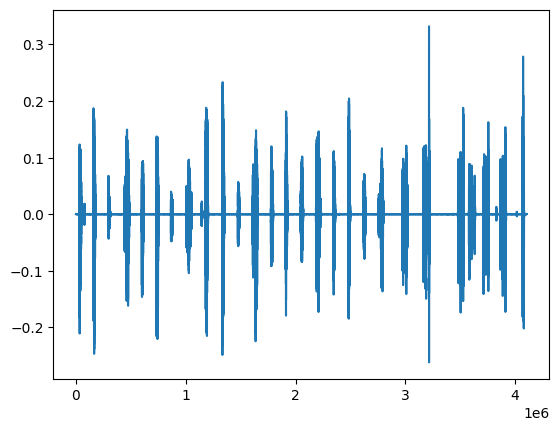

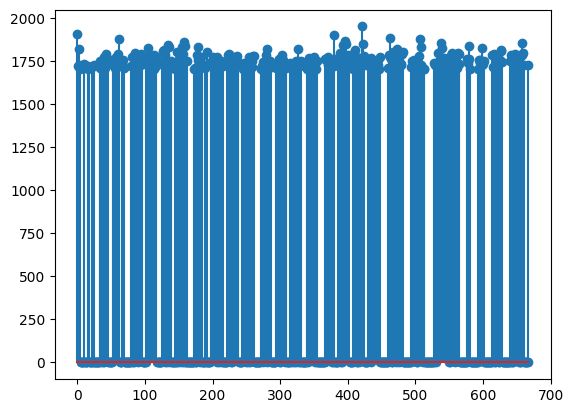

In [21]:
fixed_length = 8191  # mel 16
overlap = 2048
step = fixed_length - overlap
st = 0
en = st + step
zcs_list = []
while en < N:
    sample = wav_input[st:en]
    # print(sample)
    tmp_zcs = librosa.zero_crossings(sample, pad=False).sum()
    # print(np.mean(tmp_rms))
    if tmp_zcs < 1700:
        tmp_zcs = 0
    zcs_list.append(tmp_zcs)
    st = en
    en += step

plt.figure(0)
plt.plot(range(N), wav_input)
plt.show()
plt.figure(1)
plt.stem(range(len(zcs_list)),zcs_list)
plt.show()

In [8]:
zcs = librosa.zero_crossings(y, pad=False)
print(zcs)
print(zcs.shape)
print(zcs.sum())

[False False False  True False False False False False False False False
 False False False  True False False  True False False False False False
 False]
(25,)
3


## 4.2 尝试一下线性判别分析
- 因为我需要的分类任务就是最精准的线性分类
- 但是我感觉我不需要分类，我已经手动找阈值了，标签我都是通过阈值赋予的，那我还分什么类啊！！！
- 说起来我的目标，不就是识别静音吗！！！

In [ ]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## 进行Region Proposal的方法之我的想法
- 根据我的调查，从RCNN开始就有的方法，先进行Region Proposal，具体方法，以及输出后的处理我不清楚，我怀疑不同region尺寸不一样大无法组成Batch。
- 关注一下Bounding-Boxes的选取
- YOLO里面提到了Anchor，锚框的选择值得关注
- 我的想法则是最古老的方法，滑动窗口，带重叠。可以先试试。

In [ ]:
wav2mel = Wave2Mel(sr=22050)

In [ ]:
test_len = [8192, 4068, 6144, 7168, 7679, 7680, 7681, 8191, 8192]
for length in test_len:
    test_x = torch.from_numpy(np.random.rand(length)).to(torch.float32)
    x_mel = wav2mel(test_x)
    print(length, x_mel.shape)


In [ ]:
number = 8191
for factor in range(2, int(np.sqrt(number))+2):
    if number % factor == 0:
        print(factor, number/factor)
print("prime")

In [ ]:
sample_path = "F:/DATAS/NEUCOUGHDATA_FULL/20240921104740_audiodata_元音字母a.wav"
# pool_size = [8, 8, 2]
params = {"pool_size": [8, 8, 2], "dropout_rate": 0.0, "batch_size": 32, "nb_cnn2d_filt": 64,
          "rnn_size": [128, 128], "fnn_size": [256, 128, 32]}
device = torch.device("cuda")
model = CRNN(params=params).to(device)
model.load_state_dict(torch.load("./runs/sed_crnn/{}/epoch_{}_sedmodel.pth".format("202411152222", 19)))
model.eval()
print(model)

# sample_list, label_list = read_fullwave_file()
lab2name = {0: "non-cough", 1: "cough"}
fixed_length = 8191  # mel 16
overlap = 2048

In [ ]:
wav_input, sr = librosa.load(sample_path)
N = len(wav_input)
st = 0
st_list = []
yhat_list = []
while st < N:
    sample = wav_input[st:st+fixed_length-overlap]
    x_mel = wav2mel(torch.from_numpy(sample).to(torch.float32))
    x_mel = x_mel.unsqueeze(0).to(device)
    print("start:{}, x_mel.shape:{}".format(st, x_mel.shape))
    with torch.no_grad():
        y_pred, _ = model(x_mel)
        y_hat = torch.argmax(y_pred, dim=-1)
        st_list.append(st)
        yhat_list.append(y_hat)
    st += fixed_length

In [ ]:
yhat_list = [item.data.cpu().numpy() for item in yhat_list]

In [ ]:
plt.figure(1)
plt.stem(range(len(yhat_list)), yhat_list)
plt.show()

# End